In [1]:
import stlab
import stlabutils
import numpy as np
import pickle as pkl
import multiprocessing as mp
import matplotlib.pyplot as plt

from numpy import tan, pi, sqrt
from numpy.fft import fft, ifft
from scipy.optimize import minimize, curve_fit
from scipy.constants import e,h,hbar,k,G,epsilon_0
from lmfit import Model, Parameters
phi_0 = hbar/2./e
import matplotlib.pyplot as plt
%matplotlib inline
from qutip import *
from scipy import signal
import matplotlib as mpl
from plotsettings import *

In [2]:
# Specify the path to your data file
folder = '/home/jovyan/thesis/'
file = 'B113_2020_01_01_18.11.18_LT142W4_5D_c_60dB-prove_40dB_pump.dat'
filepath = folder + file

# Load the data
data = stlabutils.readdata.readdat(filepath)

# Specify what data you want to use for the parameter fitting
block = data[4]
xdata = np.asarray(block['Frequency (Hz)'])
ydata = np.asarray(block['CH2_S21_S1im ()'])

power_dBm = list()
for block in data:
    power_dBm.append(block['power (dBm)'][0])
power_W = 10**(np.asarray(power_dBm)/10)/1e3

['Frequency (Hz)', 'CH2_S21_S1re ()', 'CH2_S21_S1im ()', 'CH2_S21_S1dB (dB)', 'CH2_S21_S1Ph (rad)', 'power (dBm)']


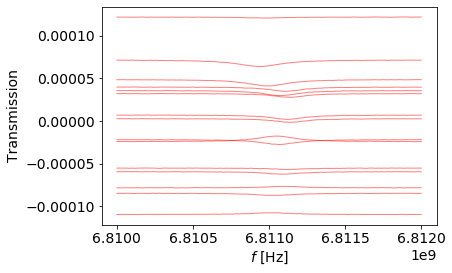

In [3]:
plt.figure()
for i in range(len(data)-1):
    plt.plot(xdata, data[i]['CH2_S21_S1im ()'], 'r', label='Data', alpha=0.5)
plt.xlabel("$f$ [Hz]")
plt.ylabel("Transmission")
# plt.legend()
plt.show()

In [4]:
def lorentzian(x, x0, amp, gamma, offset):
    return amp*(0.5*gamma/((x-x0)**2+0.25*gamma**2)/pi) + offset

toplocs = list()
toplocs_std = list()

for block in data:
    xdata = np.asarray(block['Frequency (Hz)']) / 1e9
    ydata = np.asarray(block['CH2_S21_S1im ()'])

    Lmodel = Model(lorentzian)
    result = Lmodel.fit(ydata, x=xdata, x0=6.81100, amp=-2e-3, gamma=10e-6, offset=0)
    
    xrange = np.linspace(6.81, 6.82, 10000)
    x0 = result.best_values['x0']
    amp = result.best_values['amp']
    gamma = result.best_values['gamma']
    offset = result.best_values['offset']
    
    x0_err = result.params['x0'].stderr
    fit = lorentzian(xrange, x0, amp, gamma, offset)
    
    start = fit[0]
    end   = fit[-1]
    minimum = min(fit)
    maximum = max(fit)
    if minimum in (start, end):
        toplocs.append(xrange[fit.tolist().index(maximum)])
    elif maximum in (start, end):
        toplocs.append(xrange[fit.tolist().index(minimum)])
    toplocs_std.append(x0_err)
    
#     plt.figure()
#     plt.plot(xdata, ydata, 'ro', label='Data', alpha=0.5)
#     plt.plot(xdata, result.best_fit, 'b')
#     plt.xlabel("$f$ [Hz]")
#     plt.ylabel("Transmission")
#     plt.show()
#     plt.close()

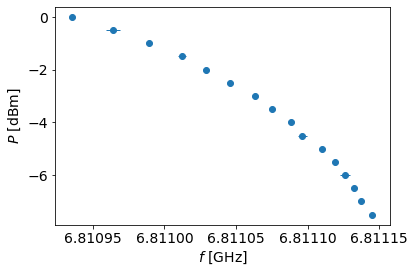

In [5]:
plt.figure()
plt.errorbar(toplocs, power_dBm, xerr=toplocs_std, fmt='o')
plt.xlabel("$f$ [GHz]")
plt.ylabel("$P$ [dBm]")
plt.show()

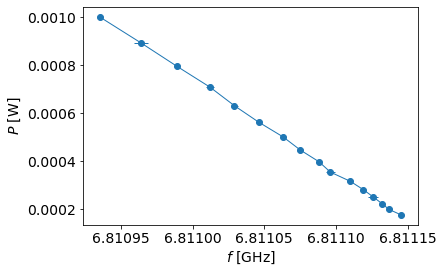

In [55]:
plt.figure()
plt.errorbar(toplocs, power_W, xerr=toplocs_std, fmt='o-')
plt.xlabel("$f$ [GHz]")
plt.ylabel("$P$ [W]")
plt.show()

In [13]:
linmodel = Model(lambda x, a, b : a*x + b)
linresult = linmodel.fit(power_W, x=toplocs, a=0, b=0.001)
a = linresult.best_values['a']
b = linresult.best_values['b']
da = linresult.params['a'].stderr
db = linresult.params['b'].stderr
chi = .655e-3
print(a)
print(b)

-3.958381951898517
26.961287254817325


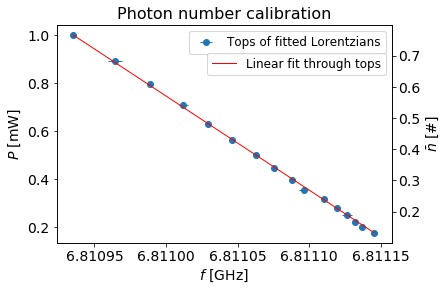

In [53]:
def n(f):
    return (a*f + b)/(2*chi)

fig, ax1 = plt.subplots()
ax1.set_ylabel("$P$ [mW]")
ax2 = ax1.twinx()
ax1.errorbar(toplocs, 1000*power_W, xerr=toplocs_std, fmt='o', label="Tops of fitted Lorentzians")
ax2.plot(toplocs, n(np.asarray(toplocs)), c='r', label="Linear fit through tops")
ax1.set_xlabel("$f$ [GHz]")
ax2.set_ylabel("$\\bar{n}$ [#]")
# ax1.set_xlim([6.81093, 6.81130])
# ax2.set_ylim([0.0, 0.8])
plt.title("Photon number calibration")
ax1.legend(bbox_to_anchor=(0.4, 0.9, 0.6, 0.1))
ax2.legend(bbox_to_anchor=(0.4, 0.8, 0.6, 0.1))
plt.show()

In [54]:
f0 = -b/a
print(f0)

6.811188910632074
